In [1]:
import numpy as np
import gc

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Input,
    BatchNormalization,
    Concatenate,
    GlobalAveragePooling2D,
    Conv2DTranspose,
    concatenate,
)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, plot_model

from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
    ImageDataGenerator,
)

from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import cv2

from PIL import Image

from glob import glob
from pathlib import Path
from typing import Generator

import random

random_state = 123456
random.seed(random_state)

2025-05-20 18:59:06.344526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 18:59:06.344633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 18:59:06.344646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 18:59:06.357527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/marroj/miniconda3/envs/dee

In [2]:
def smooth_data(data_frame, window_size=10):

    window = 2 * window_size + 1  
    return data_frame.rolling(window=window, min_periods=1, center=True).mean()

In [3]:

def load_data(path: str = "../dataset") -> Generator[np.array, float, float]:
    csv_paths = glob(f"{path}/*.csv")
    #random.shuffle(csv_paths)
    
    for csv_path in csv_paths:
        csv_data = pd.read_csv(csv_path, header=None)
        csv_data.columns = ["id", "forward", "left"]
        
        #csv_data = smooth_data(csv_data)
        
        image_paths = glob(f"{csv_path.removesuffix('.csv')}/*.jpg")
        #random.shuffle(image_paths)
        
        for image_path in image_paths:
            image_data = load_img(image_path)
            image_number = int(Path(image_path).name.removesuffix(".jpg"))
            row = csv_data[csv_data["id"]==image_number]
            if row.empty:
                continue
            yield image_data, row["forward"].values[0], row["left"].values[0]
        

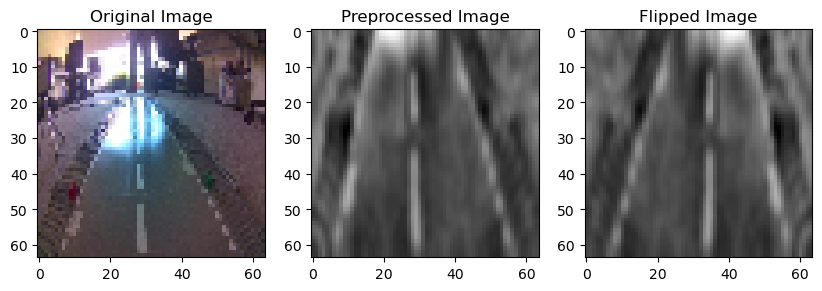

In [4]:
img_size = 64

img, _, _ = next(load_data())
img_preprocessed = img_to_array(img).astype(np.uint8)

img_og= cv2.resize(img_preprocessed, (img_size, img_size))

img_gray = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img_gray)
img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)

img_crop = img_blurred[img_size//2:img_size, 0:img_size]
img_crop = cv2.resize(img_crop, (img_size, img_size))
    
img_preprocessed = img_crop

pil_preprocessed = Image.fromarray(img_preprocessed.astype(np.uint8), "L")

pil_flipped = pil_preprocessed.transpose(method=Image.FLIP_LEFT_RIGHT)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img_og)
ax[0].set_title("Original Image")
ax[1].imshow(pil_preprocessed, cmap='gray')
ax[1].set_title("Preprocessed Image")
ax[2].imshow(pil_flipped, cmap='gray')
ax[2].set_title("Flipped Image")
plt.show()


In [5]:
def load_data_preprocess(path, image_size, batch_size, preprocess = True, augmentation = True):
    def preprocess(image):
        ...
    
    def augment(image, forward, left):
        ...
        
    data_loader = load_data(path)
    batch_images = []
    batch_labels = []

    for image, forward, left in data_loader:
        #image = cv2.resize(image, (image_size, image_size))
        #image = preprocess(image)
    
        batch_images.append(image)
        batch_labels.append([forward, left])

        if len(batch_images) == batch_size:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images = []
            batch_labels = []
            
    if batch_images:
        yield np.array(batch_images), np.array(batch_labels)

In [6]:
image_size = 64
loader = load_data_preprocess("../dataset", image_size, 64, False, False)

In [7]:
images, labels = next(loader)

for i in range(0, 64, 2):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    
    print("OG type: ", type(images[i]))
    image_content = images[i]
    
    image_content = cv2.cvtColor(image_content, cv2.COLOR_BGR2GRAY)
    img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image_content)
    img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    
    img_crop = img_blurred[image_size//2:image_size, 0:image_size]
    img_crop = cv2.resize(img_crop, (image_size, image_size))
    
    img_preprocessed = img_crop
    
    img_augmented = cv2.flip(img_preprocessed, 1)
    
    print("New type: ", type(image_content))
    print("labels: ", labels[i])
    ax[0].imshow(images[i])
    ax[0].set_title("Original Image")
    ax[1].imshow(img_preprocessed, cmap="gray")
    ax[1].set_title("Preprocessed Image")
    ax[0].axis("off")
    ax[1].axis("off")
    
    ax[2].imshow(img_augmented, cmap="gray")
    ax[2].set_title("Augmented Image")
    ax[2].axis("off")
    plt.show()

/tmp/ipykernel_59117/20067756.py:20: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  yield np.array(batch_images), np.array(batch_labels)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (64,) + inhomogeneous part.